If you were to find segments, what would you do about them? Would anyone in your organization use them? Why and how? Are the differences found large enough to be meaningful for your business? Among various solutions you might find, are there organizational efforts or politics that would make one solution more or less influential than another?

In [1]:
load("segdf-Rintro-Ch5.RData")
seg.raw <- seg.df
seg.df <- seg.raw[ , -7]

In [2]:
summary(seg.df)

      age           gender        income            kids        ownHome   
 Min.   :19.26   Female:157   Min.   : -5183   Min.   :0.00   ownNo :159  
 1st Qu.:33.01   Male  :143   1st Qu.: 39656   1st Qu.:0.00   ownYes:141  
 Median :39.49                Median : 52014   Median :1.00               
 Mean   :41.20                Mean   : 50937   Mean   :1.27               
 3rd Qu.:47.90                3rd Qu.: 61403   3rd Qu.:2.00               
 Max.   :80.49                Max.   :114278   Max.   :7.00               
  subscribe  
 subNo :260  
 subYes: 40  
             
             
             
             

### Clustering
- Transform the data if needed for a particular clustering method; for instance, some methods require all numeric data (e.g., kmeans(), mclust()) or all categorical data (e.g., poLCA()).
- Compute a distance matrix if needed; some methods require a precomputed matrix of similarity in order to group observations (e.g., hclust()) .
- Apply the clustering method and save its result to an object. For some methods this requires specifying the number (K) of groups desired (e.g., kmeans(), poLCA()).
- For some methods, further parse the object to obtain a solution with K groups (e.g., hclust()).
- Examine the solution in the model object with regard to the underlying data, and consider whether it answers a business question.

In [3]:
seg.summ <- function(data, groups) {
    aggregate(data, list(groups), function(x) mean(as.numeric(x))) }

In [4]:
seg.summ(seg.df, seg.raw$Segment)

Group.1      age gender   income     kids  ownHome subscribe
1  Moving up 36.33114   1.30 53090.97 1.914286 1.328571     1.200
2 Suburb mix 39.92815   1.52 55033.82 1.920000 1.480000     1.060
3  Travelers 57.87088   1.50 62213.94 0.000000 1.750000     1.125
4  Urban hip 23.88459   1.60 21681.93 1.100000 1.200000     1.200

In [5]:
library(cluster)                  # daisy works with mixed data types
seg.dist <- daisy(seg.df)
as.matrix(seg.dist)[1:5, 1:5]

1         2         3         4         5
1 0.0000000 0.2532815 0.2329028 0.2617250 0.4161338
2 0.2532815 0.0000000 0.0679978 0.4129493 0.3014468
3 0.2329028 0.0679978 0.0000000 0.4246012 0.2932957
4 0.2617250 0.4129493 0.4246012 0.0000000 0.2265436
5 0.4161338 0.3014468 0.2932957 0.2265436 0.0000000

#### hclust()

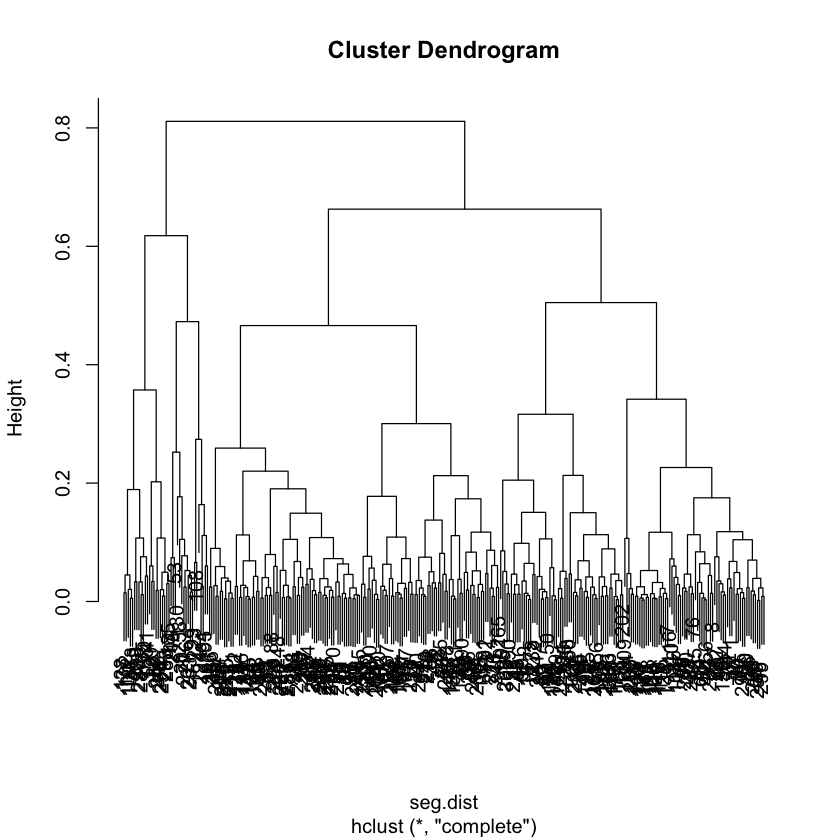

In [6]:
seg.hc <- hclust(seg.dist, method="complete")
plot(seg.hc)

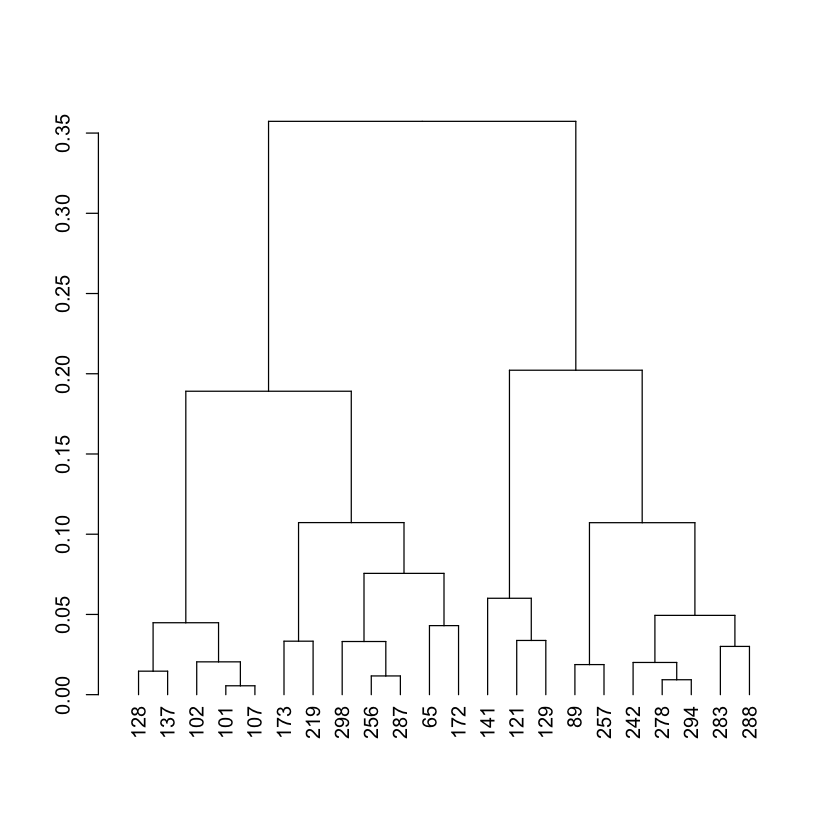

In [7]:
plot(cut(as.dendrogram(seg.hc), h=0.5)$lower[[1]])

In [8]:
seg.df[c(101, 107), ]  # similar
seg.df[c(278, 294), ]  # similar
seg.df[c(173, 141), ]  # less similar

age gender   income kids ownHome subscribe
101 24.73796   Male 18457.85    1   ownNo    subYes
107 23.19013   Male 17510.28    1   ownNo    subYes

age gender   income kids ownHome subscribe
278 36.23860 Female 46540.88    1   ownNo    subYes
294 35.79961 Female 52352.69    1   ownNo    subYes

age gender   income kids ownHome subscribe
173 64.70641   Male 45517.15    0   ownNo    subYes
141 25.17703 Female 20125.80    2   ownNo    subYes

Finally, we might check one of the goodness-of-fit metrics for a hierarchical clus- ter solution. One method is the cophenetic correlation coefficient (CPCC), which assesses how well a dendrogram (in this case seg.hc) matches the true distance metric (seg.dist) [145]. We use cophenetic() to get the distances from the dendrogram, and compare it to the dist() metrics with cor():

In [9]:
cor(cophenetic(seg.hc), seg.dist)

[1] 0.7682436

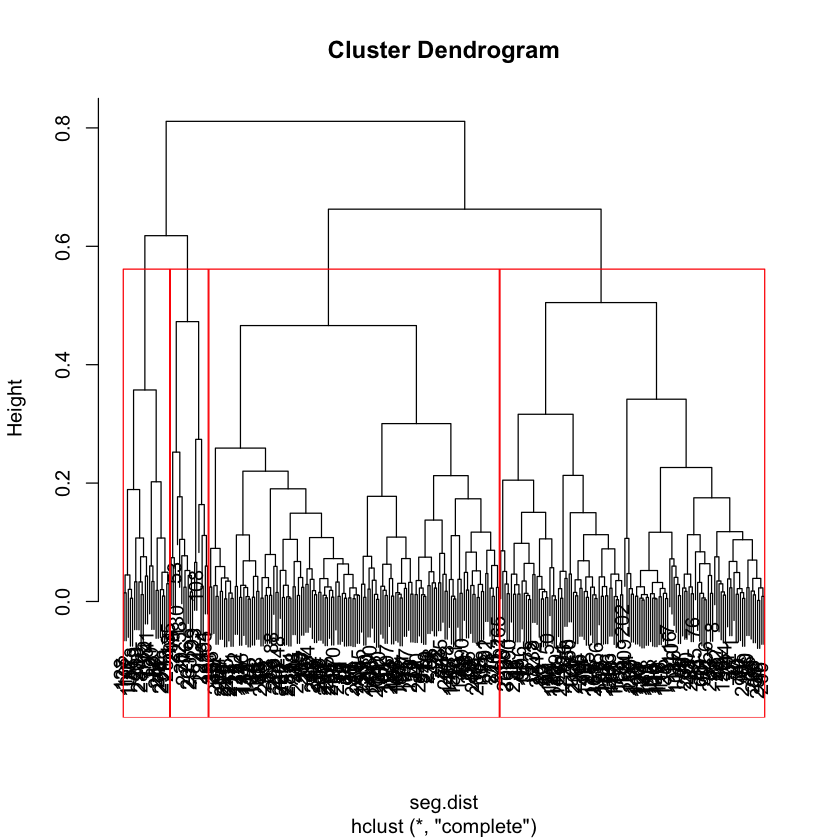

In [10]:
plot(seg.hc)
rect.hclust(seg.hc, k=4, border="red")

In [11]:
seg.hc.segment <- cutree(seg.hc, k=4)     # membership vector for 4 groups
table(seg.hc.segment)

seg.hc.segment
  1   2   3   4 
124 136  18  22 

In [12]:
seg.summ(seg.df, seg.hc.segment)

Group.1      age   gender   income     kids  ownHome subscribe
1       1 40.78456 2.000000 49454.08 1.314516 1.467742         1
2       2 42.03492 1.000000 53759.62 1.235294 1.477941         1
3       3 44.31194 1.388889 52628.42 1.388889 2.000000         2
4       4 35.82935 1.545455 40456.14 1.136364 1.000000         2

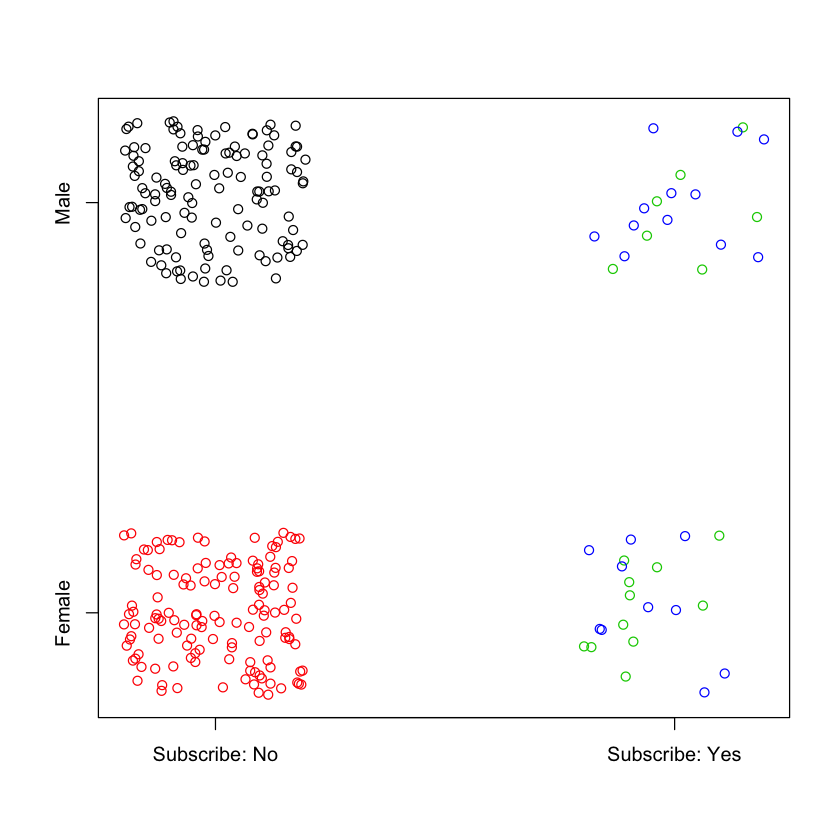

In [13]:
plot(jitter(as.numeric(seg.df$gender)) ~ jitter(as.numeric(seg.df$subscribe)), 
     col=seg.hc.segment, yaxt="n", xaxt="n", ylab="", xlab="")
axis(1, at=c(1, 2), labels=c("Subscribe: No", "Subscribe: Yes"))
axis(2, at=c(1, 2), labels=levels(seg.df$gender))

In this specific case, the scaling in daisy() rescales variables to [0, 1] and this will make two-category factors (gen- der, subscription status, home ownership) more influential. Overall, this demon- strates why you should expect to try several methods and iterate in order to find something useful.

#### kmeans()

In [14]:
seg.df.num <- seg.df
seg.df.num$gender    <- ifelse(seg.df$gender=="Male", 0, 1)
seg.df.num$ownHome   <- ifelse(seg.df$ownHome=="ownNo", 0, 1)
seg.df.num$subscribe <- ifelse(seg.df$subscribe=="subNo", 0, 1)

In [15]:
set.seed(96743)
seg.k <- kmeans(seg.df.num, centers=4)

In [16]:
seg.summ(seg.df, seg.k$cluster)

Group.1      age   gender   income      kids  ownHome subscribe
1       1 56.37245 1.428571 92287.07 0.4285714 1.857143  1.142857
2       2 29.58704 1.571429 21631.79 1.0634921 1.301587  1.158730
3       3 44.42051 1.452632 64703.76 1.2947368 1.421053  1.073684
4       4 42.08381 1.454545 48208.86 1.5041322 1.528926  1.165289

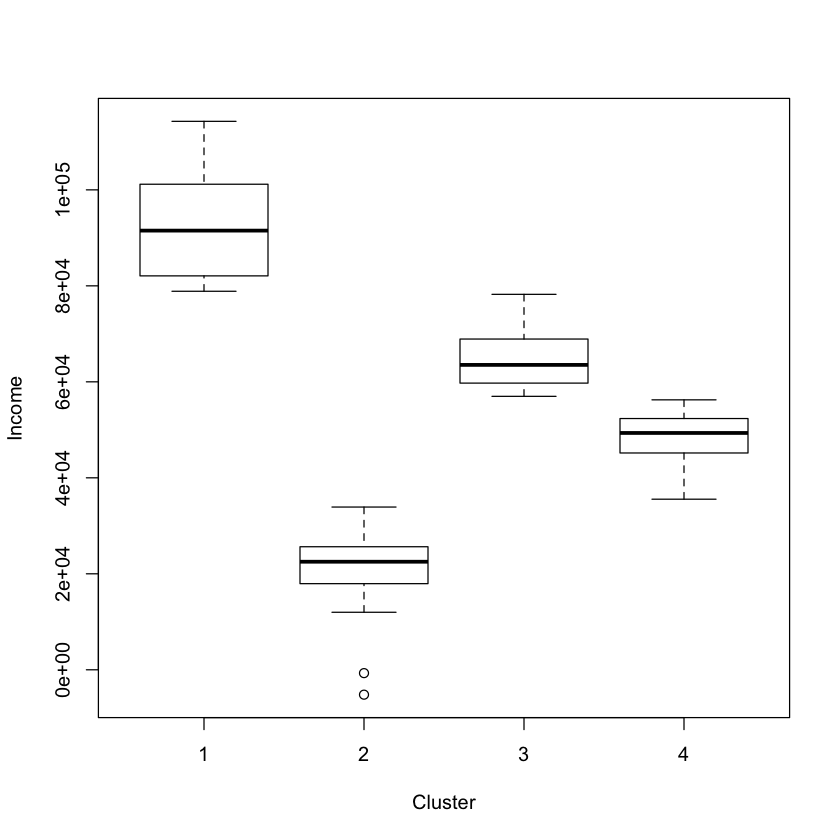

In [18]:
boxplot(seg.df.num$income ~ seg.k$cluster, ylab="Income", xlab="Cluster")

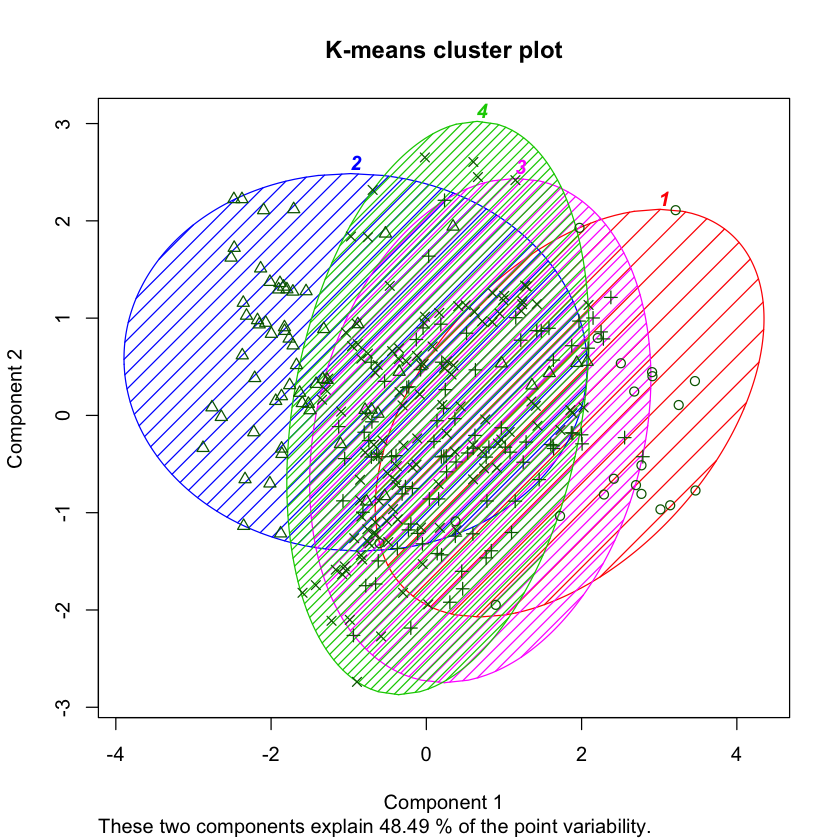

In [19]:
library(cluster)
clusplot(seg.df, seg.k$cluster, color=TRUE, shade=TRUE, 
         labels=4, lines=0, main="K-means cluster plot")

#### Model Based Clustering: Mclust()
The key idea for model-based clustering is that observations come from groups with different statistical distributions (such as different means and variances). The algorithms try to find the best set of such underlying distributions to explain the observed data. 

In [20]:
library(mclust)
seg.mc <- Mclust(seg.df.num)
summary(seg.mc)

Package 'mclust' version 5.1
Type 'citation("mclust")' for citing this R package in publications.


----------------------------------------------------
Gaussian finite mixture model fitted by EM algorithm 
----------------------------------------------------

Mclust EVE (ellipsoidal, equal volume and orientation) model with 2 components:

 log.likelihood   n df       BIC       ICL
      -5197.499 300 39 -10617.45 -10636.59

Clustering table:
  1   2 
247  53 

In [22]:
seg.mc4 <- Mclust(seg.df.num, G=4)
summary(seg.mc4)

----------------------------------------------------
Gaussian finite mixture model fitted by EM algorithm 
----------------------------------------------------

Mclust EVE (ellipsoidal, equal volume and orientation) model with 4 components:

 log.likelihood   n df       BIC       ICL
      -5325.941 300 63 -11011.22 -11127.95

Clustering table:
  1   2   3   4 
 64  54 163  19 

In [23]:
BIC(seg.mc, seg.mc4)

df     BIC
seg.mc  39 1281140
seg.mc4 63 1281276

![BIC](BIC.png)

In [24]:
seg.summ(seg.df, seg.mc$class)

Group.1      age   gender   income      kids  ownHome subscribe
1       1 40.17283 1.485830 52653.51 1.3400810 1.449393  1.000000
2       2 45.98504 1.433962 42934.79 0.9433962 1.566038  1.754717

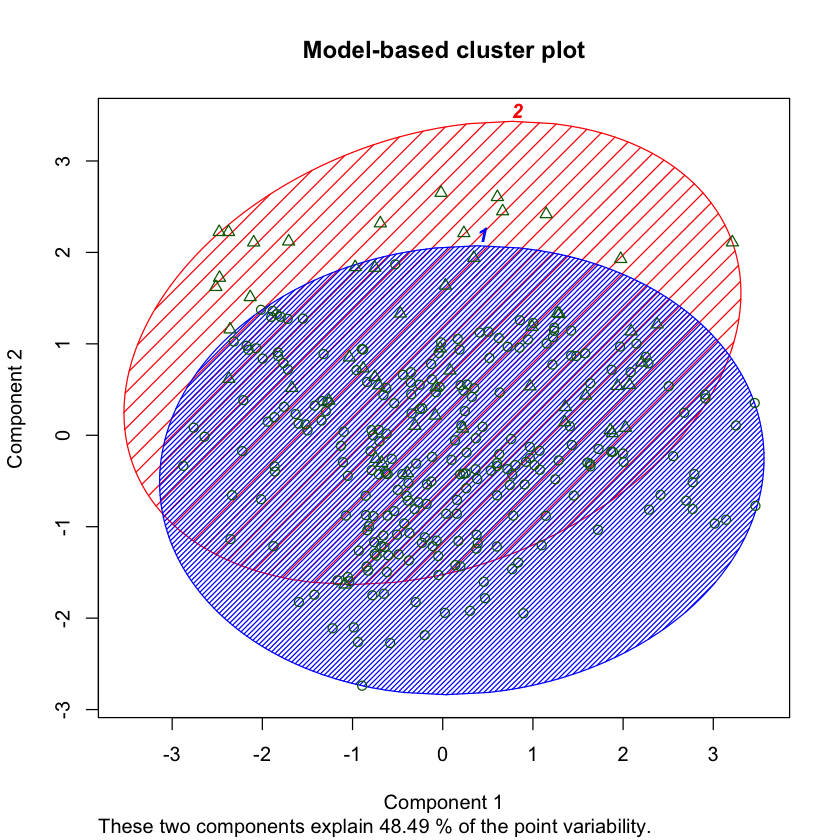

In [25]:
clusplot(seg.df, seg.mc$class, color=TRUE, shade=TRUE,
         labels=4, lines=0, main="Model-based cluster plot")

####  Latent Class Analysis: poLCA()
Whereas mclust and kmeans() work with numeric data, and hclust() de- pends on the distance measure, poLCA uses only categorical variables. 

In [26]:
seg.df.cut <- seg.df
seg.df.cut$age    <- factor(ifelse(seg.df$age < median(seg.df$age), 1, 2))
seg.df.cut$income <- factor(ifelse(seg.df$income < median(seg.df$income), 1, 2))
seg.df.cut$kids   <- factor(ifelse(seg.df$kids < median(seg.df$kids), 1, 2))
summary(seg.df.cut)

 age        gender    income  kids      ownHome     subscribe  
 1:150   Female:157   1:150   1:121   ownNo :159   subNo :260  
 2:150   Male  :143   2:150   2:179   ownYes:141   subYes: 40  

In [27]:
seg.f <- with(seg.df.cut, cbind(age, gender, income, kids, ownHome, subscribe)~1)

In [29]:
library(poLCA)
set.seed(02807)
seg.LCA3 <- poLCA(seg.f, data=seg.df.cut, nclass=3)
seg.LCA4 <- poLCA(seg.f, data=seg.df.cut, nclass=4)

Loading required package: scatterplot3d
Loading required package: MASS


Conditional item response (column) probabilities,
 by outcome variable, for each class (row) 
 
$age
               1      2
class 1:  1.0000 0.0000
class 2:  0.0000 1.0000
class 3:  0.6555 0.3445

$gender
          Female   Male
class 1:  0.4211 0.5789
class 2:  0.4681 0.5319
class 3:  0.6079 0.3921

$income
               1      2
class 1:  1.0000 0.0000
class 2:  0.3803 0.6197
class 3:  0.3746 0.6254

$kids
               1      2
class 1:  0.2818 0.7182
class 2:  0.8065 0.1935
class 3:  0.1575 0.8425

$ownHome
           ownNo ownYes
class 1:  0.7289 0.2711
class 2:  0.2338 0.7662
class 3:  0.6638 0.3362

$subscribe
           subNo subYes
class 1:  0.7496 0.2504
class 2:  0.8948 0.1052
class 3:  0.8960 0.1040

Estimated class population shares 
 0.1974 0.341 0.4616 
 
Predicted class memberships (by modal posterior prob.) 
 0.2333 0.3467 0.42 
 
Fit for 3 latent classes: 
number of observations: 300 
number of estimated parameters: 20 
residual degrees of freedom: 43 
maximum log-

In [30]:
seg.LCA4$bic
seg.LCA3$bic

[1] 2330.043

[1] 2298.767

In [31]:
seg.summ(seg.df, seg.LCA3$predclass)
table(seg.LCA3$predclass)

Group.1      age   gender   income      kids  ownHome subscribe
1       1 28.22385 1.685714 30075.32 1.1285714 1.285714  1.271429
2       2 54.44407 1.576923 60082.47 0.3846154 1.769231  1.105769
3       3 37.47652 1.277778 54977.08 2.0793651 1.325397  1.079365


  1   2   3 
 70 104 126 

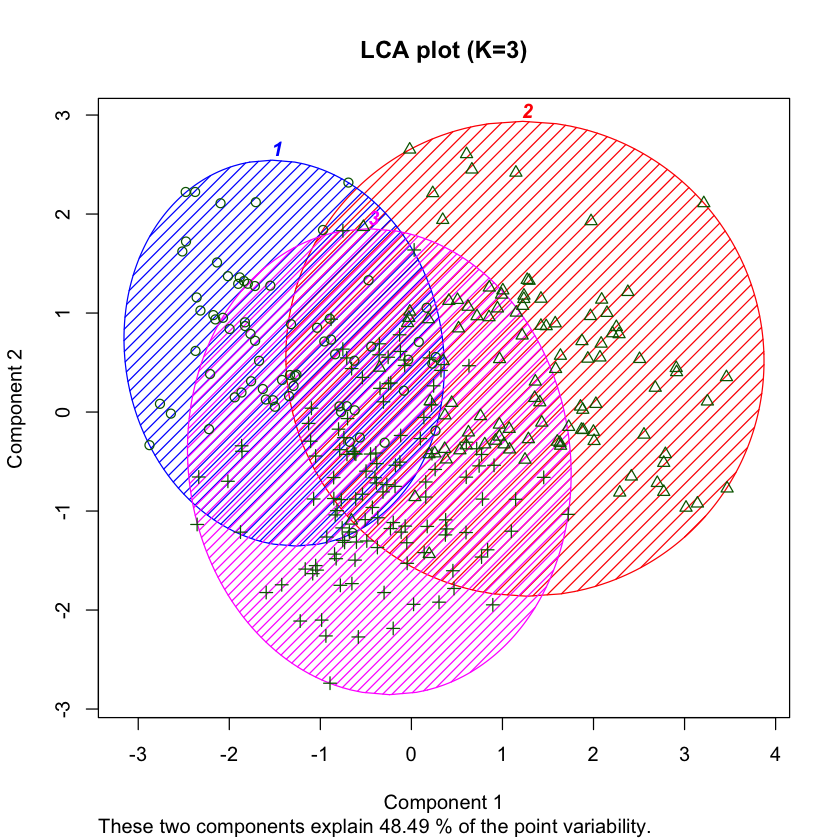

In [32]:
clusplot(seg.df, seg.LCA3$predclass, color=TRUE, shade=TRUE,
         labels=4, lines=0, main="LCA plot (K=3)")

In [33]:
seg.summ(seg.df, seg.LCA4$predclass)
table(seg.LCA4$predclass)

Group.1      age   gender   income      kids  ownHome subscribe
1       1 36.62554 1.349593 52080.13 2.1951220 1.349593  1.113821
2       2 53.64073 1.535714 60534.17 0.5178571 1.785714  1.098214
3       3 30.22575 1.050000 41361.81 0.0000000 1.350000  1.000000
4       4 27.61506 1.866667 28178.70 1.1777778 1.066667  1.333333


  1   2   3   4 
123 112  20  45 

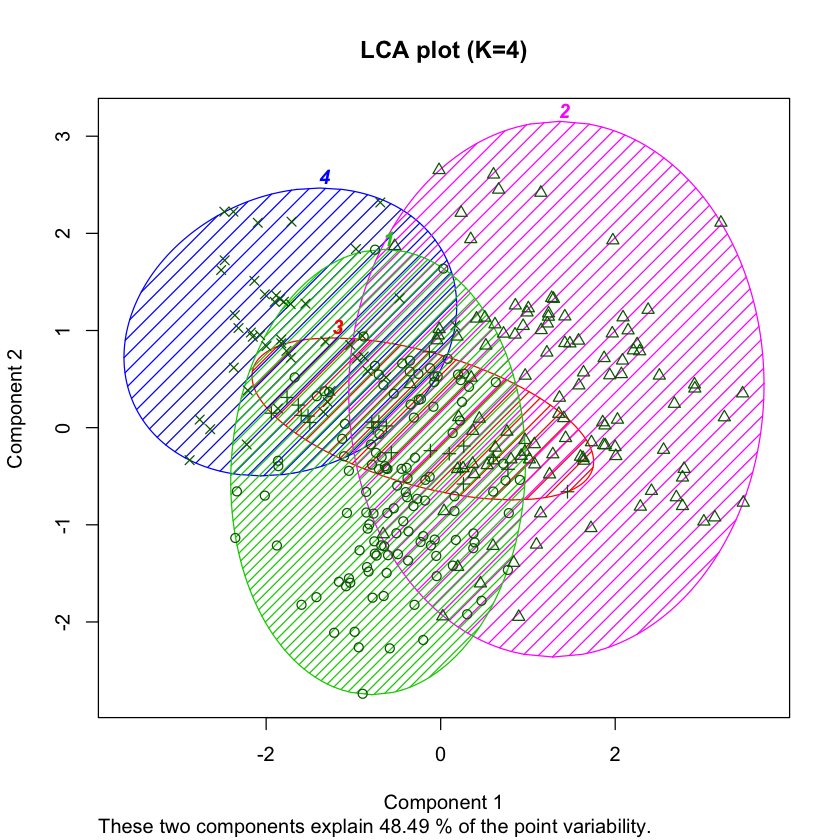

In [34]:
clusplot(seg.df, seg.LCA4$predclass, color=TRUE, shade=TRUE, 
         labels=4, lines=0, main="LCA plot (K=4)")

Does the additional group in the 4-cluster solution add anything to our interpre- tation? Turning to the quick summary from seg.summ() in the code block, we see good differentiation of groups in both models. One argument in favor of the 4-cluster solution is that Group 3 has no subscribers (as shown by the mean in the seg.summ() results) and is relatively well identified (mostly younger women with no kids); that might make it an appealing group either for targeting or exclusion, de- pending on one’s strategy.

In [35]:
table(seg.LCA3$predclass, seg.LCA4$predclass)

   
      1   2   3   4
  1  13   0  12  45
  2   0 104   0   0
  3 110   8   8   0

In [37]:
mapClass(seg.LCA3$predclass, seg.LCA4$predclass)$aTOb
adjustedRandIndex(seg.LCA3$predclass, seg.LCA4$predclass)

$`1`
[1] 4

$`2`
[1] 2

$`3`
[1] 1

[1] 0.7288822

In [38]:
# compare the LCA 4-cluster solution to the true segments in seg.raw
table(seg.raw$Segment, seg.LCA4$predclass)
adjustedRandIndex(seg.raw$Segment, seg.LCA4$predclass)

            
              1  2  3  4
  Moving up  50  4  8  8
  Suburb mix 62 29  2  7
  Travelers   0 79  1  0
  Urban hip  11  0  9 30

[1] 0.3513031

### Classification
#### Naive Bayes Classification: naiveBayes()

In [39]:
set.seed(04625)
train.prop  <- 0.65
train.cases <- sample(nrow(seg.raw), nrow(seg.raw)*train.prop)
seg.df.train <- seg.raw[train.cases, ]
seg.df.test  <- seg.raw[-train.cases, ]

In [41]:
library(e1071)
(seg.nb <- naiveBayes(Segment ~ ., data=seg.df.train))


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
 Moving up Suburb mix  Travelers  Urban hip 
 0.2512821  0.3025641  0.2615385  0.1846154 

Conditional probabilities:
            age
Y                [,1]     [,2]
  Moving up  36.09168 4.167010
  Suburb mix 40.14240 5.173803
  Travelers  57.47194 8.126370
  Urban hip  23.95040 1.798332

            gender
Y               Female      Male
  Moving up  0.6530612 0.3469388
  Suburb mix 0.4576271 0.5423729
  Travelers  0.4705882 0.5294118
  Urban hip  0.3333333 0.6666667

            income
Y                [,1]      [,2]
  Moving up  52880.45  9836.682
  Suburb mix 54124.75 11429.940
  Travelers  63547.20 23862.123
  Urban hip  21285.99  5141.259

            kids
Y                [,1]     [,2]
  Moving up  2.102041 1.489476
  Suburb mix 1.694915 1.249196
  Travelers  0.000000 0.000000
  Urban hip  1.166667 1.108409

            ownHome
Y                o

In [44]:
seg.nb.class <- predict(seg.nb, seg.df.test)

In [45]:
prop.table(table(seg.nb.class))

seg.nb.class
 Moving up Suburb mix  Travelers  Urban hip 
 0.2285714  0.3047619  0.3428571  0.1238095 

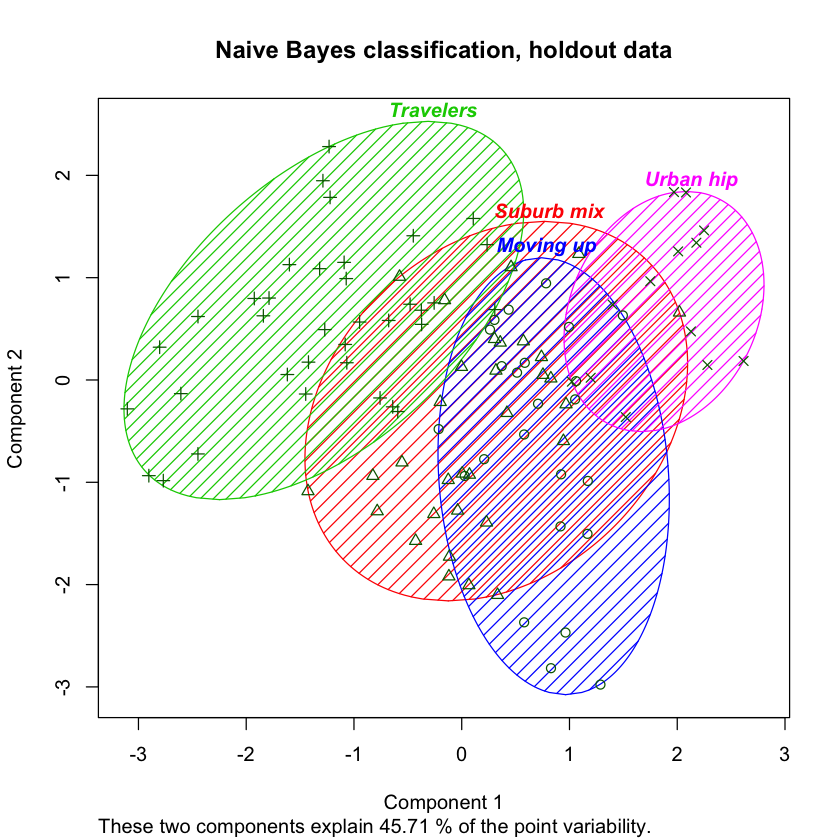

In [46]:
clusplot(seg.df.test[, -7], seg.nb.class, color=TRUE, shade=TRUE,
         labels=4, lines=0,
         main="Naive Bayes classification, holdout data")

In [47]:
mean(seg.df.test$Segment==seg.nb.class)
adjustedRandIndex(seg.nb.class, seg.df.test$Segment)

[1] 0.8

[1] 0.5626787

In [69]:
table(seg.df.test$Segment, seg.nb.class)

            seg.nb.class
             Moving up Suburb mix Travelers Urban hip
  Moving up         13          3         5         0
  Suburb mix        10         29         2         0
  Travelers          0          0        29         0
  Urban hip          1          0         0        13

In [49]:
seg.summ(seg.df.test, seg.nb.class)
seg.summ(seg.df.test, seg.df.test$Segment)

Group.1      age   gender   income      kids  ownHome subscribe  Segment
1  Moving up 34.29258 1.125000 51369.52 2.2916667 1.416667  1.250000 1.541667
2 Suburb mix 41.24653 1.562500 58095.10 2.1875000 1.562500  1.000000 1.906250
3  Travelers 55.08669 1.444444 58634.10 0.0000000 1.666667  1.166667 2.666667
4  Urban hip 23.36047 1.461538 22039.69 0.8461538 1.307692  1.153846 4.000000

Group.1      age   gender   income      kids  ownHome subscribe Segment
1  Moving up 36.88989 1.190476 53582.16 1.4761905 1.333333  1.190476       1
2 Suburb mix 39.61984 1.487805 56341.99 2.2439024 1.585366  1.048780       2
3  Travelers 58.57245 1.448276 59869.24 0.0000000 1.689655  1.206897       3
4  Urban hip 23.71537 1.428571 22700.06 0.9285714 1.357143  1.142857       4

In [58]:
predict(seg.nb, seg.df.test, type="raw")

ERROR: Error in `rownames<-`(`*tmp*`, value = c(NA, NA, NA, NA, NA, NA, NA, NA, : length of 'dimnames' [1] not equal to array extent


For high-cost campaigns, we might target only those most certain to be in a segment; whereas for low-cost campaigns, we might target people for second-best segment membership in addition to primary segment assignment.

#### Random Forest Classification: randomForest()

In [59]:
library(randomForest)
set.seed(98040)
(seg.rf <- randomForest(Segment ~ ., data=seg.df.train, ntree=3000))

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.



Call:
 randomForest(formula = Segment ~ ., data = seg.df.train, ntree = 3000) 
               Type of random forest: classification
                     Number of trees: 3000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 24.1%
Confusion matrix:
           Moving up Suburb mix Travelers Urban hip class.error
Moving up         29         19         0         1  0.40816327
Suburb mix        20         35         3         1  0.40677966
Travelers          0          3        48         0  0.05882353
Urban hip          0          0         0        36  0.00000000

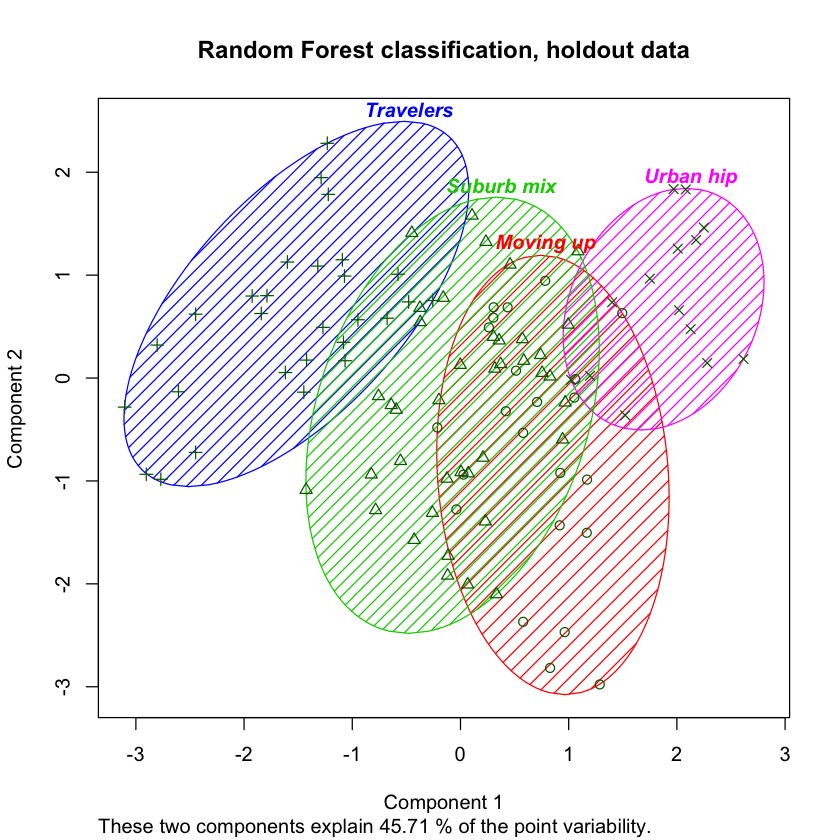

In [60]:
seg.rf.class <- predict(seg.rf, seg.df.test)
clusplot(seg.df.test[, -7], seg.rf.class, color=TRUE, shade=TRUE, 
         labels=4, lines=0, main="Random Forest classification, holdout data")

In [61]:
seg.rf.class.all <- predict(seg.rf, seg.df.test, predict.all=TRUE)
apply(seg.rf.class.all$individual[1:5, ], 1, table) / 3000

2           3         4         6     7
Moving up  0.42066667 0.076333333 0.1886667 0.1223333 0.217
Suburb mix 0.47266667 0.485000000 0.6930000 0.8526667 0.340
Travelers  0.02966667 0.436333333 0.1173333 0.0240000 0.050
Urban hip  0.07700000 0.002333333 0.0010000 0.0010000 0.393

In [67]:
seg.summ(seg.df.test, seg.rf.class) 
seg.summ(seg.df.test, seg.df.test$Segment)

Group.1      age   gender   income       kids  ownHome subscribe  Segment
1  Moving up 34.60317 1.130435 52288.38 2.39130435 1.434783  1.260870 1.608696
2 Suburb mix 40.83221 1.500000 57652.19 1.65000000 1.550000  1.000000 1.850000
3  Travelers 59.26118 1.464286 59812.04 0.03571429 1.714286  1.214286 2.892857
4  Urban hip 24.37450 1.500000 21842.73 1.00000000 1.285714  1.142857 3.857143

Group.1      age   gender   income      kids  ownHome subscribe Segment
1  Moving up 36.88989 1.190476 53582.16 1.4761905 1.333333  1.190476       1
2 Suburb mix 39.61984 1.487805 56341.99 2.2439024 1.585366  1.048780       2
3  Travelers 58.57245 1.448276 59869.24 0.0000000 1.689655  1.206897       3
4  Urban hip 23.71537 1.428571 22700.06 0.9285714 1.357143  1.142857       4

In [68]:
mean(seg.df.test$Segment==seg.rf.class)
table(seg.df.test$Segment, seg.rf.class)

[1] 0.7428571

            seg.rf.class
             Moving up Suburb mix Travelers Urban hip
  Moving up         11          9         1         0
  Suburb mix        11         28         1         1
  Travelers          0          3        26         0
  Urban hip          1          0         0        13

In [70]:
adjustedRandIndex(seg.df.test$Segment, seg.rf.class)

[1] 0.4659346

An RF model assesses the importance of a variable in a simple yet powerful way: for each variable, it randomly permutes (sorts) the variable’s values, computes the model accuracy in OOB data using the permuted values, and compares that to the accuracy with the real data. If the variable is important, then its performance will degrade when its observed values are randomly permuted. If, however, the model remains just as accurate as it is with real data, then the variable in question is not very important.

The lower block shows two overall measures of variable importance, the permu- tation measure of impact on accuracy (MeanDecreaseAccuracy), and an assess- ment of the variable’s ability to assist classification better than chance labeling (MeanDecreaseGini, a measure of Gini impurity [19]).

In [71]:
set.seed(98040)
(seg.rf <- randomForest(Segment ~ ., data=seg.df.train, ntree=3000,
                        importance=TRUE))
importance(seg.rf)


Call:
 randomForest(formula = Segment ~ ., data = seg.df.train, ntree = 3000,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 3000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 23.59%
Confusion matrix:
           Moving up Suburb mix Travelers Urban hip class.error
Moving up         29         19         0         1  0.40816327
Suburb mix        19         36         3         1  0.38983051
Travelers          0          3        48         0  0.05882353
Urban hip          0          0         0        36  0.00000000

Moving up Suburb mix   Travelers Urban hip MeanDecreaseAccuracy
age       61.386693  44.653251 121.9187436 86.345025           130.712724
gender    13.065763  -4.266584  -1.6609796  8.409029             7.382935
income    23.712016  17.428848  15.9978527 77.258853            68.809768
kids      18.476067  14.248174  53.8039237  6.308172            52.404913
ownHome    5.212246 -11.539183  23.5491524 20.667305            16.063356
subscribe 16.625874   9.118376   0.8989833 -3.194460            16.023871
          MeanDecreaseGini
age              62.399834
gender            3.354667
income           36.439804
kids             20.081438
ownHome           4.898022
subscribe         2.965571

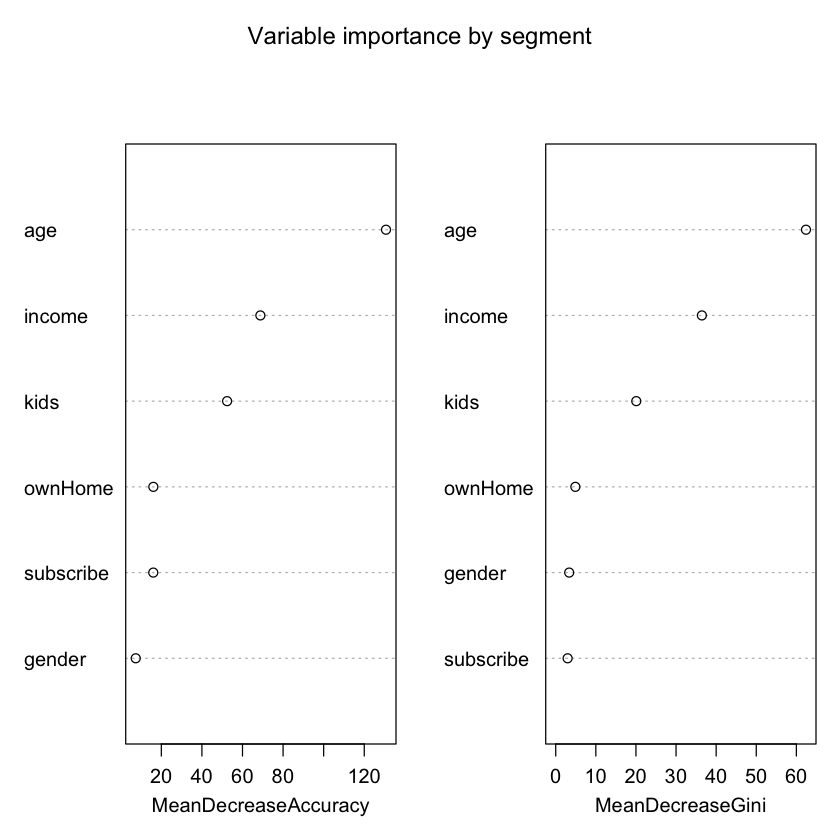

In [72]:
varImpPlot(seg.rf, main="Variable importance by segment")

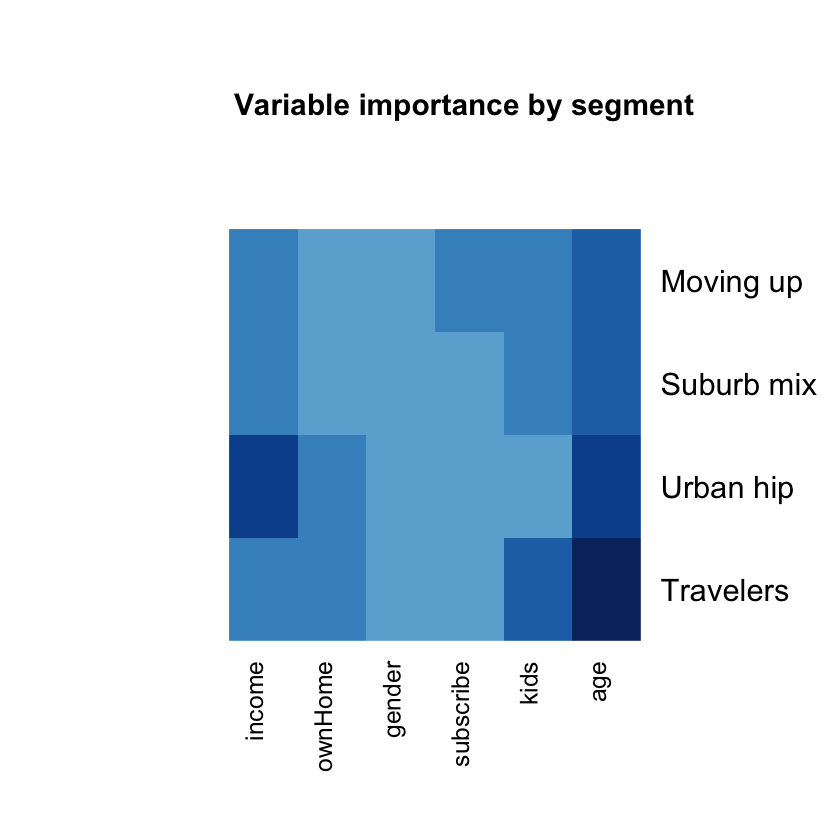

In [88]:
library(gplots)
library(RColorBrewer)
heatmap.2(t(importance(seg.rf)[ , 1:4]), 
          col=brewer.pal(9, "Blues"), 
          dend="none", trace="none", key=FALSE,
          margins=c(10, 10),
          main="\n\n\n       Variable importance by segment"
          )

### Prediction: Identifying Potential Customers

In [89]:
set.seed(92118)
train.prop  <- 0.65
train.cases <- sample(nrow(seg.df), nrow(seg.df)*train.prop)
sub.df.train <- seg.raw[train.cases, ]
sub.df.test  <- seg.raw[-train.cases, ]

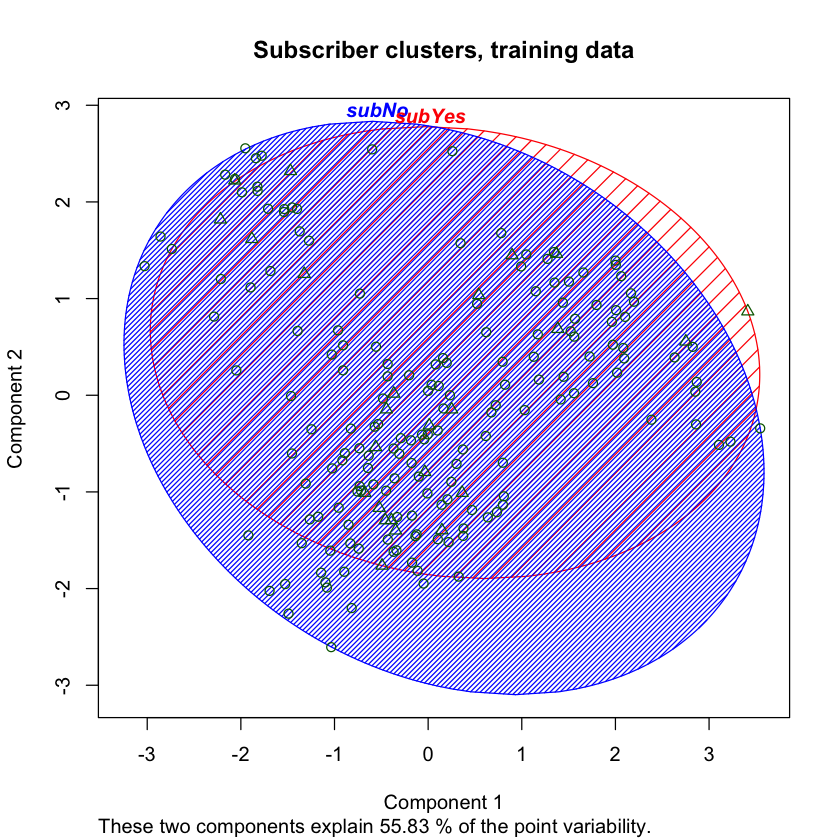

In [90]:
clusplot(sub.df.train[, -6], sub.df.train$subscribe, color=TRUE, shade=TRUE,
         labels=4, lines=0, main="Subscriber clusters, training data")

In [91]:
library(randomForest)
set.seed(11954)
(sub.rf <- randomForest(subscribe ~ ., data=sub.df.train, ntree=3000))


Call:
 randomForest(formula = subscribe ~ ., data = sub.df.train, ntree = 3000) 
               Type of random forest: classification
                     Number of trees: 3000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 14.87%
Confusion matrix:
       subNo subYes class.error
subNo    166      4  0.02352941
subYes    25      0  1.00000000

In [93]:
set.seed(11954)
(sub.rf <- randomForest(subscribe ~ ., data=sub.df.train, ntree=3000, sampsize=c(25, 25)) )


Call:
 randomForest(formula = subscribe ~ ., data = sub.df.train, ntree = 3000,      sampsize = c(25, 25)) 
               Type of random forest: classification
                     Number of trees: 3000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 30.77%
Confusion matrix:
       subNo subYes class.error
subNo    127     43   0.2529412
subYes    17      8   0.6800000

In [94]:
sub.rf.sub <- predict(sub.rf, sub.df.test)
table(sub.df.test$subscribe, sub.rf.sub)

        sub.rf.sub
         subNo subYes
  subNo     79     11
  subYes     9      6

In [95]:
adjustedRandIndex(sub.rf.sub, sub.df.test$subscribe)

[1] 0.1928668

In [96]:
library(psych)
cohen.kappa(cbind(sub.rf.sub, sub.df.test$subscribe))


Attaching package: ‘psych’

The following object is masked from ‘package:randomForest’:

    outlier

The following object is masked from ‘package:mclust’:

    sim



Call: cohen.kappa1(x = x, w = w, n.obs = n.obs, alpha = alpha)

Cohen Kappa and Weighted Kappa correlation coefficients and confidence boundaries 
                 lower estimate upper
unweighted kappa 0.025     0.26   0.5
weighted kappa   0.025     0.26   0.5

 Number of subjects = 105 

- The most crucial question in a segmentation project is the business aspect: will the results be useful for the purpose at hand? Will they inspire new strategies for marketing to customers? It is important to try multiple methods and evaluate the utility of their results (cf. Sect. 11.1.1).
- Distance-based clustering methods attempt to group similar observations. We examined hclust() for hierarchical clustering (Sect. 11.3.2) and kmeans() for k-means grouping (Sect. 11.3.4). Distance-based measures rely on having a way to express metric distance, which is a challenge for categorical data.
- Model-based clustering methods attempt to model an underlying distribution that the data express. We examined mclust for model-based clustering of data assumed to be a mix of normal distributions (Sect. 11.3.5), and poLCA for latent-class analysis with categorical data (Sect. 11.3.7).
- A feature of some model-based methods is that they propose the number of clusters, unlike distance-based measures in which the analyst must choose a number. We saw how to estimate the number of groups using the mclust pro- cedure (Sect. 11.3.5).
- BIC can compare models with the best statistical fit (Sect.11.3.5). We rec- ommend that the ultimate decision to use a model’s solution be made on the grounds of both statistics (i.e., excellent fit) and the business applicability of the solution (i.e., actionable implications).
- With classification models, data should be split into training and test groups, and models validated on the test (holdout) data (Sect. 11.4).
- We examined naive Bayes models (naiveBayes(), Sect. 11.4.1) and ran- dom forest models (randomForest(), Sect. 11.4.2). These—and many other classification methods—have quite similar syntax, making it easy to try and compare models.
- A useful feature of random forest models is their ability to determine variable importance for prediction, even when there are a large number of variables (Sect. 11.4.3).
- A common problem in classification is class imbalance, where one group dom- inates the observations and makes it difficult to predict the other group. We saw how to correct this for random forest models with the sampsize argument, resulting in a more successful predictive model (Sect. 11.5).